In [8]:
#@title Functions to generate Seq2Seq Dataset, one hot encode / decode Input & Output Sequences
#@title Import Libraries
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
import tensorflow as tf
from tensorflow.keras import models
from numpy import array_equal
import keras
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

In [9]:

# generate a sequence of random integers
def generate_sequence(length, n_unique):
        return [randint(1, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
        encoding = list()
        for value in sequence:
            vector = [0 for _ in range(n_unique)]
            vector[value] = 1
            encoding.append(vector)
        return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_reversed_pairs(time_steps,vocabulary_size,verbose= False):
        # generate random sequence
        sequence_in = generate_sequence(time_steps, vocabulary_size)
        sequence_out = sequence_in[::-1]

        # one hot encode
        X = one_hot_encode(sequence_in, vocabulary_size)
        y = one_hot_encode(sequence_out, vocabulary_size)
        # reshape as 3D
        X = X.reshape((1, X.shape[0], X.shape[1]))
        y = y.reshape((1, y.shape[0], y.shape[1]))

        if(verbose):
            print("\nNotes:")
            print('1. For each input sequence (X), selecting ',time_steps,
                  ' random numbers between 1 (inclusive) and ',
                  vocabulary_size, ' (exclusive) ')
            print("2. 0 is reserved as the SART Symbol")

            print('\nA sample X ')
            print('X=%s' % (one_hot_decode(X[0])))
            print('\nreversed input sequence (X) is the output sequence (y) ')
            print('y=%s' % (one_hot_decode(y[0])))

            print('\nEach input and output sequences are converted one_hot_encoded format in ',
                  vocabulary_size,' dimensions')
            print('X=%s' % (X[0]))
            print('y=%s' % (y[0]))
        return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):
        pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
        pairs=np.array(pairs).squeeze()
        X_train = pairs[:,0]
        y_train = pairs[:,1]
        pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
        pairs=np.array(pairs).squeeze()
        X_test = pairs[:,0]
        y_test = pairs[:,1]	

        if(verbose):
            print('\nGenerated sequence datasets as follows (batch_size,time_steps, features)')
            print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
            print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)

        return X_train, y_train, X_test, 	y_test

In [10]:
#@title Configure problem

n_timesteps_in =   4#@param {type:"integer"}
#each input sample has 4 values

n_features = 10   #@param {type:"integer"}
#each value is one_hot_encoded with 10 0/1


# generate random sequence
X,y = get_reversed_pairs(n_timesteps_in,  n_features, verbose=True)
# generate datasets
train_size= 2000 #@param {type:"integer"}
test_size = 200  #@param {type:"integer"}

X_train, y_train , X_test, 	y_test=create_dataset(train_size, test_size, n_timesteps_in,n_features , verbose=True)




Notes:
1. For each input sequence (X), selecting  4  random numbers between 1 (inclusive) and  10  (exclusive) 
2. 0 is reserved as the SART Symbol

A sample X 
X=[8, 4, 3, 4]

reversed input sequence (X) is the output sequence (y) 
y=[4, 3, 4, 8]

Each input and output sequences are converted one_hot_encoded format in  10  dimensions
X=[[0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
y=[[0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]]

Generated sequence datasets as follows (batch_size,time_steps, features)
X_train.shape:  (2000, 4, 10) y_train.shape:  (2000, 4, 10)
X_test.shape:  (200, 4, 10) y_test.shape:  (200, 4, 10)


In [11]:

def enc_dec_model(batch_size,units=16):
    # encoder part
    encoder_inputs = keras.layers.Input(shape=(n_timesteps_in,n_features),name='encoder_inputs')
    encoder_lstm= keras.layers.LSTM(units,return_state=True, name = 'encoder_lstm')
    encoder_ouputs,state_h,state_c = encoder_lstm(encoder_inputs)
    
    # initialcontext vector is the states of encoder
    states = [state_h,state_c]
    
    # decoder part
    # decoder recieves 1 token at a time and outputs 1 token at a time
    decoder_inputs = keras.layers.Input(shape=(1,n_features)) # n_features cuz of one hot representation
    decoder_lstm = keras.layers.LSTM(units,return_state=True,
                        return_sequences=True,name= 'decoder_lstm')
    decoder_dense = keras.layers.Dense(n_features,activation='softmax',name='decoder_dense')
    
    all_ouputs = []
    
    # Prepare decoder initial input data: just contains the START character 0
    # Note that we made it a constant one-hot-encoded in the model
    # that is, [1 0 0 0 0 0 0 0 0 0] = 0 is the initial input for each loop
    decoder_input_data = np.zeros((batch_size,1,n_features))
    decoder_input_data[:,0,1] = 1
    
    inputs = decoder_input_data
    # decoder will only process one time step at a time
    # loop for fixed number of time steps: n_timesteps_in
    for _ in range(n_timesteps_in):
        # run the decoder on one time step
        outputs, state_h, state_c = decoder_lstm(inputs,initial_state = states)
        
        outputs = decoder_dense(outputs)
        # store the current prediction
        all_ouputs.append(outputs)
        # reinject the ouputs as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h,state_c]
    # we got our prediction as one hot vector so now time to concatenate all the predictions such as [batch_size,timesteps,features]
    decoder_outputs = Lambda(lambda x: K.concatenate(x,axis=1))(all_ouputs)
    
    # define and compile model
    model = Model(encoder_inputs,decoder_outputs,name='model_encoder_decoder')
    model.compile(optimizer = 'rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [12]:
batch_size =10
model_encoder_decoder =  enc_dec_model(batch_size=batch_size)
model_encoder_decoder.summary()

Model: "model_encoder_decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 16), (None,  1728        encoder_inputs[0][0]             
__________________________________________________________________________________________________
tf_op_layer_MatMul_3 (TensorFlo [(None, 64)]         0           encoder_lstm[0][1]               
__________________________________________________________________________________________________
tf_op_layer_AddV2_6 (TensorFlow [(10, 64)]           0           tf_op_layer_MatMul_3[0][0]       
______________________________________________________________________________

In [13]:
"""model_encoder_decoder.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=30,
          validation_split=0.2)"""

'model_encoder_decoder.fit(X_train, y_train,\n          batch_size=batch_size,\n          epochs=30,\n          validation_split=0.2)'

training for  30  epochs begins with EarlyStopping(monitor= val_loss, patience= 5 )....
Epoch 1/30
180/180 [==============================] - 2s 12ms/step - loss: 1.5056 - accuracy: 0.3914 - val_loss: 1.4785 - val_accuracy: 0.4125
Epoch 2/30
180/180 [==============================] - 3s 19ms/step - loss: 1.4641 - accuracy: 0.4004 - val_loss: 1.4402 - val_accuracy: 0.4138
Epoch 3/30
180/180 [==============================] - 3s 19ms/step - loss: 1.4258 - accuracy: 0.4135 - val_loss: 1.3988 - val_accuracy: 0.4225
Epoch 4/30
180/180 [==============================] - 3s 18ms/step - loss: 1.3864 - accuracy: 0.4224 - val_loss: 1.3594 - val_accuracy: 0.4375
Epoch 5/30
180/180 [==============================] - 3s 19ms/step - loss: 1.3459 - accuracy: 0.4378 - val_loss: 1.3240 - val_accuracy: 0.4537
Epoch 6/30
180/180 [==============================] - ETA: 0s - loss: 1.3064 - accuracy: 0.45 - 2s 12ms/step - loss: 1.3053 - accuracy: 0.4544 - val_loss: 1.2782 - val_accuracy: 0.4825
Epoch 7/30
1

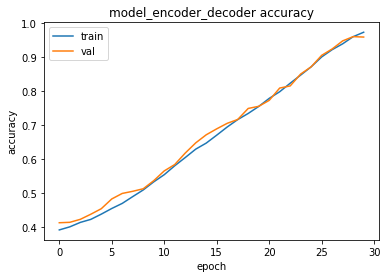

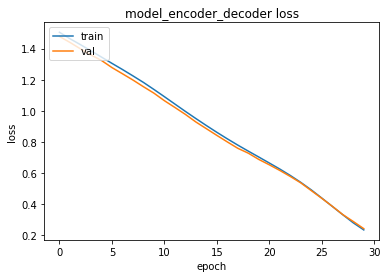

10 examples from test data...
Input          Expected       Predicted         T/F
[2, 4, 3, 4]   [4, 3, 4, 2]   [4, 3, 4, 2]   True
[4, 4, 5, 7]   [7, 5, 4, 4]   [7, 5, 4, 4]   True
[6, 3, 5, 4]   [4, 5, 3, 6]   [4, 5, 3, 6]   True
[4, 2, 4, 5]   [5, 4, 2, 4]   [5, 4, 2, 4]   True
[1, 8, 2, 1]   [1, 2, 8, 1]   [1, 2, 8, 1]   True
[4, 5, 6, 5]   [5, 6, 5, 4]   [5, 6, 5, 4]   True
[5, 1, 7, 5]   [5, 7, 1, 5]   [5, 7, 1, 5]   True
[7, 1, 9, 1]   [1, 9, 1, 7]   [1, 9, 1, 7]   True
[7, 5, 9, 4]   [4, 9, 5, 7]   [4, 9, 5, 7]   True
[2, 7, 8, 7]   [7, 8, 7, 2]   [7, 8, 7, 2]   True
Accuracy:  1.0


In [15]:
#@title Function to Train & Test  given model (Early Stopping monitor 'val_loss')
def train_test(model, X_train, y_train , X_test, 	y_test, epochs=500, batch_size=32, patience=5,verbose=0):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
	# train model
	print('training for ',epochs,' epochs begins with EarlyStopping(monitor= val_loss, patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, batch_size=batch_size, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()




  
	# spot check some examples
	space = 3*len(one_hot_decode(y_test[0]))
	print('10 examples from test data...')
	print('Input',' '*(space-4) ,'Expected',' '*(space-7) ,
	      'Predicted',' '*(space-5) ,'T/F')
	correct =0 
	sampleNo =  10

	predicted= model_encoder_decoder.predict(X_test[:sampleNo], batch_size=batch_size)
	for sample in range(0,sampleNo):
		if (one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample])):
			correct+=1
		print( one_hot_decode(X_test[sample]), ' ', 
					one_hot_decode(y_test[sample]),' ', one_hot_decode(predicted[sample]),
					' ',one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample]))
	print('Accuracy: ', correct/sampleNo)
	

train_test(model_encoder_decoder, X_train, y_train , X_test, 	y_test, batch_size=batch_size,epochs=30, verbose=1)